<a href="https://colab.research.google.com/github/mhdykz/mhdykz-Implementation-of-neural-network/blob/main/neural%20network%20with%20adam%20algorythm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plot



In [38]:
# Read train and test data
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')


In [39]:
# Filling missing values of 'Age' and 'Fare' columns with mean
train_data['Age'].fillna(train_data['Age'].mean(), inplace=True)
test_data['Age'].fillna(test_data['Age'].mean(), inplace=True)

train_data['Fare'].fillna(train_data['Fare'].mean(), inplace=True)
test_data['Fare'].fillna(test_data['Fare'].mean(), inplace=True)

# Filling 'Embarked' column with the mode
train_data['Embarked'].fillna(train_data['Embarked'].mode()[0], inplace=True)
test_data['Embarked'].fillna(test_data['Embarked'].mode()[0], inplace=True)

In [40]:
# Convert categorical columns to numeric
train_data = pd.get_dummies(train_data, columns=['Sex', 'Embarked'], drop_first=True)
test_data = pd.get_dummies(test_data, columns=['Sex', 'Embarked'], drop_first=True)

In [41]:
# Normalization of 'Age' and 'Fare'
scaler = StandardScaler()
train_data[['Age', 'Fare']] = scaler.fit_transform(train_data[['Age', 'Fare']])
test_data[['Age', 'Fare']] = scaler.transform(test_data[['Age', 'Fare']])

In [42]:
# Select input properties and labels
Xtrain = train_data[['Pclass', 'Sex_male', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked_Q', 'Embarked_S']]
Ytrain = train_data['Survived']
Xtest = test_data[['Pclass', 'Sex_male', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked_Q', 'Embarked_S']]

Xtrain = np.array(Xtrain, dtype=float)
Xtest = np.array(Xtest, dtype=float)
Ytrain = np.array(Ytrain).reshape(-1, 1)  # Ensure Ytrain is reshaped to (m, 1)

In [43]:
# Neural network initialization
input_size = Xtrain.shape[1]
hidden_size_1 = 16  # Increased first hidden layer size
hidden_size_2 = 8  # Added second hidden layer
output_size = 1

np.random.seed(42)
W1 = np.random.randn(input_size, hidden_size_1) * np.sqrt(2. / input_size)  # He-initialization
b1 = np.zeros((1, hidden_size_1))
W2 = np.random.randn(hidden_size_1, hidden_size_2) * np.sqrt(2. / hidden_size_1)
b2 = np.zeros((1, hidden_size_2))
W3 = np.random.randn(hidden_size_2, output_size) * np.sqrt(2. / hidden_size_2)
b3 = np.zeros((1, output_size))

In [44]:
# Adam Optimizer parameters
learning_rate = 0.001
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8
mW1, mb1, mW2, mb2, mW3, mb3 = 0, 0, 0, 0, 0, 0
vW1, vb1, vW2, vb2, vW3, vb3 = 0, 0, 0, 0, 0, 0

In [45]:
# Neural network functions
def forward_pass(X, W1, b1, W2, b2, W3, b3):
    z1 = np.dot(X, W1) + b1
    a1 = np.maximum(0, z1)  # ReLU activation for first layer
    z2 = np.dot(a1, W2) + b2
    a2 = np.maximum(0, z2)  # ReLU activation for second layer
    z3 = np.dot(a2, W3) + b3
    y_hat = 1 / (1 + np.exp(-z3))  # Sigmoid output
    return y_hat, z1, a1, z2, a2


In [46]:
def backpropagation(X, y, y_hat, z1, a1, z2, a2, W2, W3):
    m = X.shape[0]

    dz3 = (y_hat - y)
    dW3 = np.dot(a2.T, dz3) / m
    db3 = np.sum(dz3, axis=0, keepdims=True) / m

    dz2 = np.dot(dz3, W3.T) * (z2 > 0)  # ReLU derivative
    dW2 = np.dot(a1.T, dz2) / m
    db2 = np.sum(dz2, axis=0, keepdims=True) / m

    dz1 = np.dot(dz2, W2.T) * (z1 > 0)  # ReLU derivative
    dW1 = np.dot(X.T, dz1) / m
    db1 = np.sum(dz1, axis=0, keepdims=True) / m

    return dW1, db1, dW2, db2, dW3, db3


In [47]:
def adam_update(W, b, dW, db, mW, mb, vW, vb, t, learning_rate, beta1, beta2, epsilon):
    mW = beta1 * mW + (1 - beta1) * dW
    mb = beta1 * mb + (1 - beta1) * db
    vW = beta2 * vW + (1 - beta2) * (dW ** 2)
    vb = beta2 * vb + (1 - beta2) * (db ** 2)

    mW_corr = mW / (1 - beta1 ** t)
    mb_corr = mb / (1 - beta1 ** t)
    vW_corr = vW / (1 - beta2 ** t)
    vb_corr = vb / (1 - beta2 ** t)

    W -= learning_rate * mW_corr / (np.sqrt(vW_corr) + epsilon)
    b -= learning_rate * mb_corr / (np.sqrt(vb_corr) + epsilon)

    return W, b, mW, mb, vW, vb


In [48]:
def predict(X, W1, b1, W2, b2, W3, b3):
    y_hat, _, _, _, _ = forward_pass(X, W1, b1, W2, b2, W3, b3)
    return (y_hat > 0.5).astype(int)

In [49]:
def train_and_evaluate(Xtrain, Ytrain, Xtest, num_iterations=2000):
    input_size = Xtrain.shape[1]
    hidden_size_1 = 16
    hidden_size_2 = 8
    output_size = 1
    np.random.seed(42)
    W1 = np.random.randn(input_size, hidden_size_1) * np.sqrt(2. / input_size)  # He-initialization
    b1 = np.zeros((1, hidden_size_1))
    W2 = np.random.randn(hidden_size_1, hidden_size_2) * np.sqrt(2. / hidden_size_1)
    b2 = np.zeros((1, hidden_size_2))
    W3 = np.random.randn(hidden_size_2, output_size) * np.sqrt(2. / hidden_size_2)
    b3 = np.zeros((1, output_size))

    # Adam optimizer variables
    mW1, mb1, mW2, mb2, mW3, mb3 = 0, 0, 0, 0, 0, 0
    vW1, vb1, vW2, vb2, vW3, vb3 = 0, 0, 0, 0, 0, 0

    losses = []
    epsilon = 1e-8

    for i in range(num_iterations):
        y_hat, z1, a1, z2, a2 = forward_pass(Xtrain, W1, b1, W2, b2, W3, b3)

        # Loss calculation with epsilon to avoid log(0)
        loss = -np.mean(Ytrain * np.log(y_hat + epsilon) + (1 - Ytrain) * np.log(1 - y_hat + epsilon))
        losses.append(loss)

        dW1, db1, dW2, db2, dW3, db3 = backpropagation(Xtrain, Ytrain, y_hat, z1, a1, z2, a2, W2, W3)

        t = i + 1
        W1, b1, mW1, mb1, vW1, vb1 = adam_update(W1, b1, dW1, db1, mW1, mb1, vW1, vb1, t, learning_rate, beta1, beta2, epsilon)
        W2, b2, mW2, mb2, vW2, vb2 = adam_update(W2, b2, dW2, db2, mW2, mb2, vW2, vb2, t, learning_rate, beta1, beta2, epsilon)
        W3, b3, mW3, mb3, vW3, vb3 = adam_update(W3, b3, dW3, db3, mW3, mb3, vW3, vb3, t, learning_rate, beta1, beta2, epsilon)

        if i % 100 == 0:
            print(f"Iteration {i}, Loss: {loss:.4f}")

    predictions = predict(Xtest, W1, b1, W2, b2, W3, b3)

    submission = pd.DataFrame({
        "PassengerId": np.arange(1, len(predictions) + 1),
        "Survived": predictions.flatten()
    })
    submission.to_csv("titanic_predictions.csv", index=False)
    return predictions, losses

Iteration 0, Loss: 0.8513
Iteration 100, Loss: 0.5416
Iteration 200, Loss: 0.4606
Iteration 300, Loss: 0.4295
Iteration 400, Loss: 0.4094
Iteration 500, Loss: 0.3956
Iteration 600, Loss: 0.3846
Iteration 700, Loss: 0.3741
Iteration 800, Loss: 0.3665
Iteration 900, Loss: 0.3616
Iteration 1000, Loss: 0.3579
Iteration 1100, Loss: 0.3546
Iteration 1200, Loss: 0.3518
Iteration 1300, Loss: 0.3482
Iteration 1400, Loss: 0.3450
Iteration 1500, Loss: 0.3425
Iteration 1600, Loss: 0.3402
Iteration 1700, Loss: 0.3360
Iteration 1800, Loss: 0.3305
Iteration 1900, Loss: 0.3262
File saved as titanic_predictions.csv


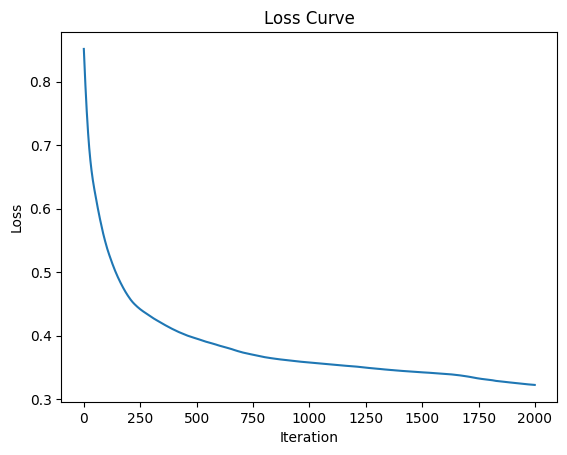

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [51]:
# Train the model
predictions, losses = train_and_evaluate(Xtrain, Ytrain, Xtest, num_iterations=2000)

# Save predictions to CSV file
submission = pd.DataFrame({
    "PassengerId": test_data['PassengerId'],
    "Survived": predictions.flatten()
})

submission.to_csv('titanic_predictions.csv', index=False)

print("File saved as titanic_predictions.csv")

# Visualize loss curve
def plot_loss_curve(losses):
    plt.plot(losses)
    plt.title("Loss Curve")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.show()


plot_loss_curve(losses)

# Download file (for Colab)
from google.colab import files
files.download('titanic_predictions.csv')